# PRISMA Uncertainty Analysis

Estimate scene-level retrieval noise for PRISMA matched-filter products by separating the propagated instrument noise $\sigma_{RMN}$ from residual clutter using plume-free pixels. The method assumes Gaussian perturbations and reuses the same algebra as the EnMAP notebook so both sensors produce comparable uncertainty summaries.

**Workflow**
1. Configure the scene metadata plus the concentration/uncertainty rasters and optional plume polygons produced by the matched-filter pipeline.
2. Rasterise plume polygons (if provided) to avoid biasing the clutter estimate with strong enhancements.
3. Build a plume-free, finite mask and compute $\sigma_{tot} = std(\Delta X)$ over those pixels.
4. Aggregate the propagated instrument-noise variance (mean/median) to obtain $\langle\sigma_{RMN}^2\rangle$ and a representative $\sigma_{RMN}$.
5. Derive $\sigma_{Surf} = \sqrt{\max(0,\sigma_{tot}^2 - \langle\sigma_{RMN}^2\rangle)}$ as the clutter/background term.
6. Combine $\sigma_{Surf}$ in quadrature with each plume pixel's $\sigma_{RMN}$ to map the total plume uncertainty, then store the metrics to JSON for reporting.


In [4]:
import os
import sys
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, ogr

In [5]:
NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

SCENE_NAME = 'PRISMA Demo Scene'
SIGMA_RMN_AGGREGATION = 'mean'  # or 'median'

CONC_PATH = REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'prisma' / 'PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_concentration.tif'
UNC_PATH = REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'prisma' / 'PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_uncertainty.tif'
PLUME_MASK_PATH = REPO_ROOT / 'notebooks' / 'outputs' / 'pipeline_demo' / 'prisma' / 'plumes_mask_prisma_20220912072502.shp'  # Optional

SUMMARY_DIR = NOTEBOOK_ROOT / 'outputs' / 'uncertainty' / 'prisma'
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)



Using plume mask: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/plumes_mask_prisma_20220912072502.shp


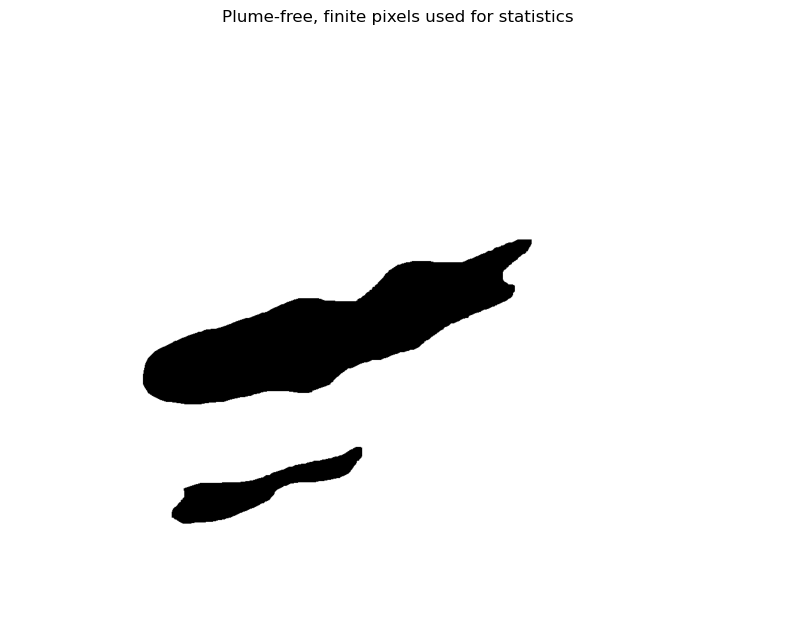

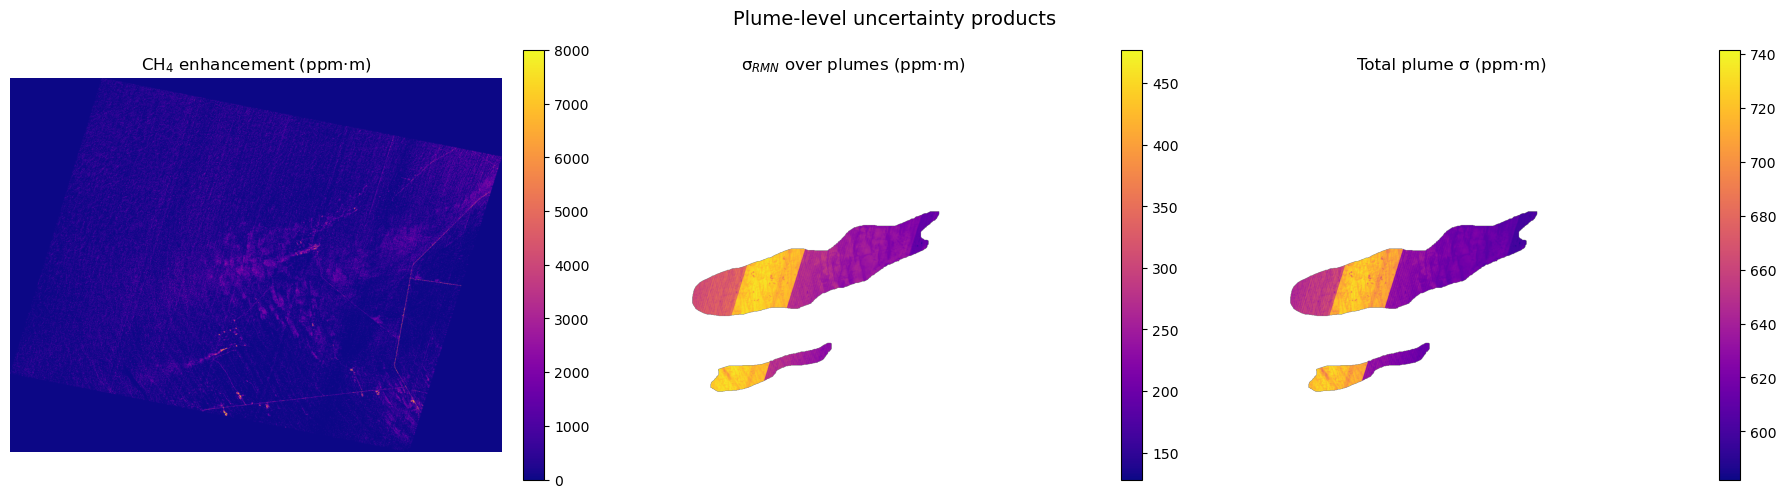

Scene noise metrics:
  scene: PRISMA Demo Scene
  concentration_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_concentration.tif
  uncertainty_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_uncertainty.tif
  plume_mask_path: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/prisma/plumes_mask_prisma_20220912072502.shp
  valid_pixels: 1184719
  plume_pixels: 88577
  sigma_tot: 608.5333251953125
  sigma_rmn_sq: 47887.1875
  sigma_rmn_value: 171.9337158203125
  sigma_surf: 567.8253431938944
  sigma_rmn_aggregation: mean
  mean_plume_sigma_rmn: 315.6189481288049
  mean_plume_sigma_total: 653.9935315840358
Saved metrics to /mnt/d/Lavor

In [6]:
def _read_raster(path: str):
    ds = gdal.Open(str(path))
    if ds is None:
        raise RuntimeError(f'Failed to open raster: {path}')
    arr = ds.ReadAsArray().astype(np.float32)
    geo = ds.GetGeoTransform()
    proj = ds.GetProjection()
    ds = None
    return arr, geo, proj


def _rasterize_vector(vector_path: str, rows: int, cols: int, geo_transform: tuple, projection: str) -> np.ndarray:
    vector_ds = ogr.Open(vector_path)
    if vector_ds is None:
        raise RuntimeError(f'Failed to open vector file: {vector_path}')
    vector_layer = vector_ds.GetLayer()
    mask_ds = gdal.GetDriverByName('MEM').Create('', cols, rows, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(geo_transform)
    mask_ds.SetProjection(projection)
    gdal.RasterizeLayer(mask_ds, [1], vector_layer, burn_values=[1])
    mask_array = mask_ds.ReadAsArray().astype(bool)
    mask_ds = None
    vector_layer = None
    vector_ds = None
    return mask_array


def _slugify(value: str) -> str:
    return ''.join(ch.lower() if ch.isalnum() else '_' for ch in value).strip('_')


def _mask_array(data: np.ndarray, mask: np.ndarray) -> np.ndarray:
    masked = np.full(data.shape, np.nan, dtype=float)
    masked[mask] = data[mask]
    return masked


concentration, geo_transform, projection = _read_raster(str(CONC_PATH))
uncertainty, _, _ = _read_raster(str(UNC_PATH))

if concentration.shape != uncertainty.shape:
    raise ValueError('Concentration and uncertainty rasters must share the same shape.')

plume_mask = None
if PLUME_MASK_PATH and PLUME_MASK_PATH.exists():
    print(f'Using plume mask: {PLUME_MASK_PATH}')
    plume_mask = _rasterize_vector(str(PLUME_MASK_PATH), concentration.shape[0], concentration.shape[1], geo_transform, projection)
    plume_free_mask = ~plume_mask
else:
    print('No plume mask provided or found. Calculating statistics over the entire scene.')
    plume_free_mask = np.ones_like(concentration, dtype=bool)

valid_mask = plume_free_mask & np.isfinite(concentration) & np.isfinite(uncertainty)
if not np.any(valid_mask):
    raise ValueError('No valid plume-free pixels available for statistics.')

plt.figure(figsize=(10, 8))
plt.imshow(valid_mask, cmap='gray')
plt.title('Plume-free, finite pixels used for statistics')
plt.axis('off')
plt.show()

delta_x = concentration[valid_mask]
sigma_tot = float(np.nanstd(delta_x, ddof=1))

sigma_rmn_vals = uncertainty[valid_mask]
agg = SIGMA_RMN_AGGREGATION.lower().strip()
if agg == 'median':
    sigma_rmn_stat = float(np.nanmedian(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmedian(sigma_rmn_vals ** 2))
else:
    sigma_rmn_stat = float(np.nanmean(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmean(sigma_rmn_vals ** 2))

sigma_surf = float(np.sqrt(max(0.0, sigma_tot ** 2 - sigma_rmn_sq)))

if plume_mask is not None:
    plume_pixels_mask = plume_mask & np.isfinite(concentration) & np.isfinite(uncertainty)
else:
    print('Plume mask missing: plume-level summaries will cover the whole scene.')
    plume_pixels_mask = np.isfinite(concentration) & np.isfinite(uncertainty)

plume_pixel_count = int(plume_pixels_mask.sum())
if plume_pixel_count == 0:
    raise ValueError('No plume pixels available for plume-level uncertainty mapping.')

plume_concentration = _mask_array(concentration, plume_pixels_mask)
plume_sigma_rmn = _mask_array(uncertainty, plume_pixels_mask)
plume_sigma_total = _mask_array(np.sqrt(np.maximum(0.0, uncertainty ** 2 + sigma_surf ** 2)), plume_pixels_mask)

plume_sigma_rmn_mean = float(np.nanmean(plume_sigma_rmn[plume_pixels_mask]))
plume_sigma_total_mean = float(np.nanmean(plume_sigma_total[plume_pixels_mask]))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im0 = axes[0].imshow(concentration, cmap='plasma', vmin=0, vmax=8000)
axes[0].set_title('CH$_4$ enhancement (ppm·m)')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(plume_sigma_rmn, cmap='plasma')
axes[1].set_title('σ$_{RMN}$ over plumes (ppm·m)')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(plume_sigma_total, cmap='plasma')
axes[2].set_title('Total plume σ (ppm·m)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

for ax in axes:
    ax.axis('off')

plt.suptitle('Plume-level uncertainty products', fontsize=14)
plt.tight_layout()
plt.show()

metrics = {
    'scene': SCENE_NAME,
    'concentration_path': str(CONC_PATH),
    'uncertainty_path': str(UNC_PATH),
    'plume_mask_path': str(PLUME_MASK_PATH) if PLUME_MASK_PATH else None,
    'valid_pixels': int(valid_mask.sum()),
    'plume_pixels': plume_pixel_count,
    'sigma_tot': sigma_tot,
    'sigma_rmn_sq': sigma_rmn_sq,
    'sigma_rmn_value': sigma_rmn_stat,
    'sigma_surf': sigma_surf,
    'sigma_rmn_aggregation': agg,
    'mean_plume_sigma_rmn': plume_sigma_rmn_mean,
    'mean_plume_sigma_total': plume_sigma_total_mean,
}

metrics_path = SUMMARY_DIR / f'{_slugify(SCENE_NAME)}_noise_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print('Scene noise metrics:')
for key, value in metrics.items():
    print(f'  {key}: {value}')
print(f'Saved metrics to {metrics_path}')



## Result interpretation
Compare $\sigma_{tot}$, representative $\sigma_{RMN}$, and derived $\sigma_{Surf}$ to understand whether the scene is detector- or clutter-limited. The plume mosaics reveal how the total uncertainty varies spatially; areas where $\Delta X$ greatly exceeds the combined uncertainty indicate robust detections, whereas marginal plumes show comparable enhancement and noise.
